In [0]:
# -*- coding: utf-8 -*-

"""
NEURAL NETWORKS AND DEEP LEARNING

ICT FOR LIFE AND HEALTH - Department of Information Engineering
PHYSICS OF DATA - Department of Physics and Astronomy
COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY - Department of Psychology

A.A. 2019/20 (6 CFU)
Dr. Alberto Testolin, Dr. Federico Chiariotti

Author: Dr. Matteo Gadaleta

Lab. 03 - Introduction to PyTorch (part 2)
 
"""

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint
from scipy.stats import uniform

np.random.seed(1)





In [0]:
#%% Operations on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Importing data

In [0]:
matdata= sio.loadmat('MNIST.mat')

In [0]:
X=[]
Y=[]
for i in range(matdata['input_images'].shape[0]):
  X.append([item for item in matdata['input_images'][i,:]])
  Y.append([item for item in matdata['output_labels'][i]])

Y = [item for sublist in Y for item in sublist]
x = np.asfarray(X )
y= np.asarray(Y, dtype='int')
x = x.astype(np.float32)
y = y.astype(np.int64)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10/60, random_state=1)


In [0]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

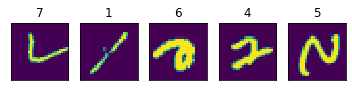

In [0]:
plot_example(x_train, y_train)


In [0]:
x_trainloader = torch.utils.data.DataLoader(x_train, batch_size=5000, shuffle=False)
y_trainloader = torch.utils.data.DataLoader(y_train, batch_size=5000, shuffle=False)
#testloader = torch.utils.data.DataLoader(x_test, batch_size=64, shuffle=False)


In [0]:
x_dataiter = iter(x_trainloader)
y_dataiter = iter(y_trainloader)
images= x_dataiter.next()
labels = y_dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([5000, 784])
torch.Size([5000])


# PYTORCH

## Defininig class

In [0]:
#%% Neural Network

### Define the network class
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        super().__init__()
        
        #self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        
    def forward(self, x, additional_out=False):
        
        x = self.act(self.fc1(x))
        #x = self.dropout(x)
        x = self.act(self.fc2(x))
        #x = self.dropout(x)
        out = self.fc3(x)
        
        if additional_out:
            return out, x
        
        return out






## Random search cross validation

In [0]:
mask=np.array(np.ones(len(x_train)), 'bool')
x_cv=[]
x_val=[]
y_cv=[]
y_val=[]

for j in range(5):
  temp_mask=mask.copy()
  temp_mask[(j*int(np.round(len(x_train)/5))):((j+1)*int(np.round(len(x_train)/5)))]=False
  x_cv.append(x_train[temp_mask])
  x_val.append(x_train[~temp_mask])
  y_cv.append(y_train[temp_mask])
  y_val.append(y_train[~temp_mask])

x_cv=np.array(x_cv)
x_val=np.array(x_val)
y_cv=np.array(y_cv)
y_val=np.array(y_val)

In [0]:
best_error= np.inf
N=10
num_epochs = 1000
Nh1_list = np.random.randint(100, 500, N)
Nh2_list = np.random.randint(50, 250, N)

### Define the loss function (the most used are already implemented in pytorch, see the doc!)
loss_fn = nn.CrossEntropyLoss()


### Define an optimizer
lr = 1e-3



### Training




for Nh1, Nh2 in zip(Nh1_list, Nh2_list):
    Ni=784
    No=10


    print('Nh1', Nh1)
    print('Nh2', Nh2)
    val_loss=0
    stopping_index=0
    c=0

    for xt,yt,xv,yv in zip(x_cv, y_cv, x_val, y_val):
        c+=1
        print(c)
        model = Net(Ni, Nh1, Nh2, No)#, dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    
        model.to(device)

        train_loss_log = []
        val_loss_log = []
        for num_epoch in range(num_epochs):
            running_loss=0.0
            #print('Epoch', num_epoch + 1)

            xt_trainloader = torch.utils.data.DataLoader(xt, batch_size=5000, shuffle=False)
            yt_trainloader = torch.utils.data.DataLoader(yt, batch_size=5000, shuffle=False)

            for input_train, label_train in zip(xt_trainloader, yt_trainloader):

                # Training
                model.train() # Training mode (e.g. enable dropout)

                optimizer.zero_grad()

                # Eventually clear previous recorded gradients

                #input_train = torch.tensor(x_train).float().view(-1,784).to(device)
                #label_train = torch.tensor(y_train).long().view(-1,1).squeeze(1).to(device)
                #input_train = torch.tensor(x_train).float().to(device)
                #label_train = torch.tensor(y_train).to(device)
                out = model(input_train.to(device))

                # Evaluate loss

                loss = loss_fn(out, label_train.to(device))
                # Backward pass
                loss.backward()
                # Update
                optimizer.step()
                # Print loss
                running_loss += loss.item()


            #print('\t Training loss ():', float(running_loss)/len(x_trainloader))
                
            # Validation
            model.eval() # Evaluation mode (e.g. disable dropout)
            with torch.no_grad(): # No need to track the gradients

                input_test = torch.tensor(xv).float().view(-1,784).to(device)
                label_test = torch.tensor(yv).long().view(-1,1).squeeze(1).to(device)
                out = model(input_test)
                # Evaluate global loss
                val_loss_epoch = loss_fn(out, label_test)
                # Print loss
                #print('\t Validation loss:', float(val_loss_epoch.data))
            


            # Log
            train_loss_log.append(float(loss.data))
            val_loss_log.append(float(val_loss_epoch.data))

            if (val_loss_log[-1]/min(val_loss_log)-1>0.01):
              break

        #average error between k-folds
        val_loss+=min(val_loss_log)/len(x_cv)
        if np.argmin(val_loss_log) > stopping_index:
            stopping_index=np.argmin(val_loss_log)

    print('mean validation error',val_loss)
    print('stopping index',stopping_index)

    #assign the best error to the lower value and choosing the parameters using it
    if val_loss < best_error:
          best_error = val_loss
          best_Nh1=Nh1
          best_Nh2=Nh2
          best_epochs = stopping_index

Nh1 322
Nh2 219
1
2
3
4
5
mean validation error 0.09733599573373795
stopping index 86
Nh1 430
Nh2 114
1
2
3
4
5
mean validation error 0.08674424141645432
stopping index 98
Nh1 236
Nh2 158
1
2
3
4
5
mean validation error 0.1020645320415497
stopping index 85
Nh1 209
Nh2 74
1
2
3
4
5
mean validation error 0.0971531480550766
stopping index 87
Nh1 199
Nh2 163
1
2
3
4
5
mean validation error 0.09802239984273911
stopping index 111
Nh1 132
Nh2 70
1
2
3
4
5
mean validation error 0.10377137809991838
stopping index 107
Nh1 108
Nh2 94
1
2
3
4
5
mean validation error 0.1065648913383484
stopping index 130
Nh1 184
Nh2 65
1
2
3
4
5
mean validation error 0.09521555602550508
stopping index 119
Nh1 150
Nh2 208
1
2
3
4
5
mean validation error 0.09960164725780488
stopping index 92
Nh1 179
Nh2 192
1
2
3
4
5
mean validation error 0.10014401227235795
stopping index 92


In [0]:
print(best_Nh1)
print(best_Nh2)
print(best_epochs)

430
114
98


## Best model

In [0]:
Ni = 784
Nh1 = best_Nh1
Nh2 = best_Nh2
No = 10
dropout = 0
model = Net(Ni, Nh1, Nh2, No)#, dropout)

### Define the loss function (the most used are already implemented in pytorch, see the doc!)
loss_fn = nn.CrossEntropyLoss()


### Define an optimizer
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
model.to(device)

### Training
train_loss_log = []
test_loss_log = []
num_epochs = best_epochs




for num_epoch in range(num_epochs):
    running_loss=0.0
    print('Epoch', num_epoch + 1)

    for input_train, label_train in zip(x_trainloader, y_trainloader):

        # Training
        model.train() # Training mode (e.g. enable dropout)

        optimizer.zero_grad()

        # Eventually clear previous recorded gradients

        #input_train = torch.tensor(x_train).float().view(-1,784).to(device)
        #label_train = torch.tensor(y_train).long().view(-1,1).squeeze(1).to(device)
        #input_train = torch.tensor(x_train).float().to(device)
        #label_train = torch.tensor(y_train).to(device)
        out = model(input_train.to(device))

        # Evaluate loss

        loss = loss_fn(out, label_train.to(device))
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Print loss
        running_loss += loss.item()


    print('\t Training loss ():', float(running_loss)/len(x_trainloader))
        
    # Validation
    model.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients

        input_test = torch.tensor(x_test).float().view(-1,784).to(device)
        label_test = torch.tensor(y_test).long().view(-1,1).squeeze(1).to(device)
        out = model(input_test)
        # Evaluate global loss
        test_loss = loss_fn(out, label_test)
        # Print loss
        print('\t Validation loss:', float(test_loss.data))
    


    # Log
    train_loss_log.append(float(loss.data))
    test_loss_log.append(float(test_loss.data))



Epoch 1
	 Training loss (): 1.938661026954651
	 Validation loss: 1.3310717344284058
Epoch 2
	 Training loss (): 0.9017098724842072
	 Validation loss: 0.5626171231269836
Epoch 3
	 Training loss (): 0.4611672401428223
	 Validation loss: 0.4018884301185608
Epoch 4
	 Training loss (): 0.3561115086078644
	 Validation loss: 0.3442224860191345
Epoch 5
	 Training loss (): 0.3092973053455353
	 Validation loss: 0.31116384267807007
Epoch 6
	 Training loss (): 0.27985123693943026
	 Validation loss: 0.2881672978401184
Epoch 7
	 Training loss (): 0.25830345451831815
	 Validation loss: 0.2689606547355652
Epoch 8
	 Training loss (): 0.24090642035007476
	 Validation loss: 0.2520527243614197
Epoch 9
	 Training loss (): 0.2250008061528206
	 Validation loss: 0.23699542880058289
Epoch 10
	 Training loss (): 0.21026453524827957
	 Validation loss: 0.22338488698005676
Epoch 11
	 Training loss (): 0.19659426361322402
	 Validation loss: 0.21084965765476227
Epoch 12
	 Training loss (): 0.18400786072015762
	 Vali

In [0]:
softmax = nn.functional.softmax(out.cpu(), dim=1).squeeze().numpy()
argmax=np.argmax(softmax, axis=1)
errors = label_test.cpu().numpy()!=argmax
#print('Class probabilities (softmax):\n ', softmax)
#print('Real classes: ', label_test)
#print('Errors: ', errors)
print('mean accuracy',1-errors.mean())

mean accuracy 0.9814


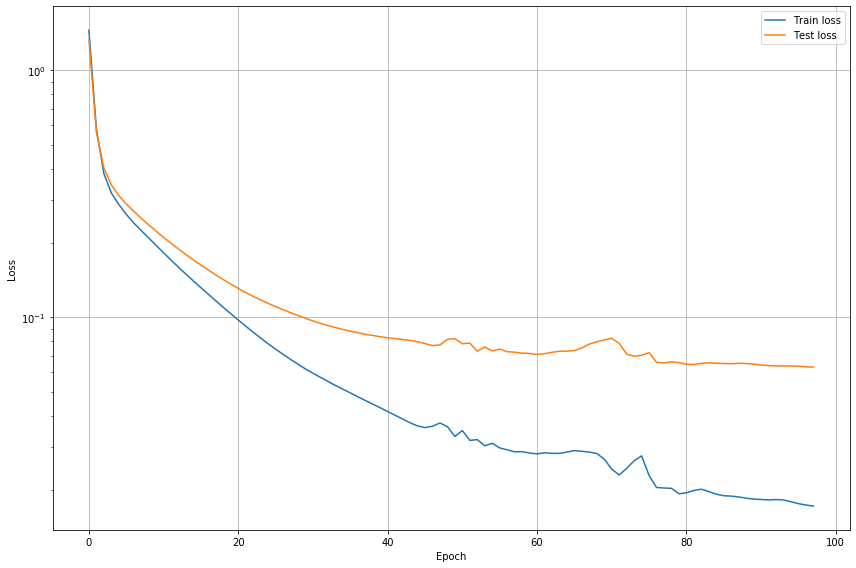

In [0]:
 
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(test_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#print(np.where(errors==1))
#print(np.where(errors==-1))

## plotting and saving

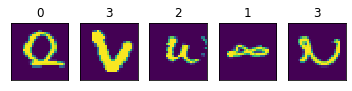

In [0]:
plot_example(x_test[errors], argmax[errors])

In [0]:
wfc1=model.fc1.weight.data.cpu().numpy()
wfc2=model.fc2.weight.data.cpu().numpy()
wfc3=model.fc3.weight.data.cpu().numpy()



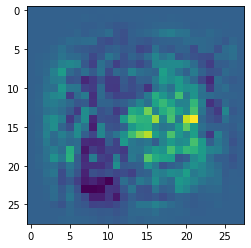

In [0]:
plt.imshow(wfc1[0].reshape(28,28) )


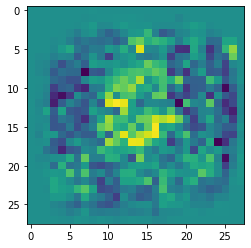

In [0]:
plt.imshow(np.matmul(wfc2[0], wfc1).reshape(28,28))


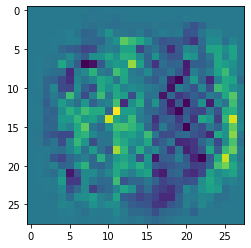

In [0]:
plt.imshow(np.matmul(wfc3[9], np.matmul(wfc2, wfc1)).reshape(28,28))

In [0]:
torch.save(model.state_dict(), 'my_pesi.pkl')



# SKORCH

In [0]:
#install the library if it is not already present!!!
pip install -U skorch

     |████████████████████████████████| 102kB 6.4MB/s 


In [0]:

from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping


## Defining class

In [0]:
#%% Neural Network


### Define the network class
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, dropout):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)


    def forward(self, X, **kwargs):
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = F.softmax(self.fc3(X), dim=-1)
        #uso la softmax sull'ultimo layer e poi il predict fa una NNLOSS
        return X


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


my_early= EarlyStopping(monitor='valid_loss')

net = NeuralNetClassifier(
    module=Net,
    module__Ni=784,
    module__No=10,
    #module__Nh1=128,
    #module__Nh2=64,
    module__dropout=0,
    
    batch_size =5000,
    max_epochs=200,
    
    verbose = 1,
    
    #callbacks=EarlyStopping,
    lr = 1e-3, 

    optimizer=torch.optim.Adam,
    device=device,
    callbacks=[my_early]

)

#net.fit(x_train, y_train )

In [0]:


hp = {
    'module__Nh1': randint(20, 400),
    'module__Nh2': randint(10, 200),
    #'module__dropout': uniform()
}


## Random search cross validation

In [0]:
rscv = RandomizedSearchCV(net, hp, n_iter=10, cv=5,  verbose=1, n_jobs=1 )
#rscv = GridSearchCV(net, hp, cv=5,  verbose=1, n_jobs=1 )


In [0]:
net.get_params().keys()

dict_keys(['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 'iterator_valid', 'dataset', 'train_split', 'callbacks', 'warm_start', 'verbose', 'device', 'module__Ni', 'module__Nh1', 'module__Nh2', 'module__No', 'module__dropout', 'history', 'initialized_', 'virtual_params_', 'callbacks_', 'criterion_', 'module_', 'optimizer_', 'callbacks__epoch_timer', 'callbacks__train_loss', 'callbacks__train_loss__scoring', 'callbacks__train_loss__lower_is_better', 'callbacks__train_loss__on_train', 'callbacks__train_loss__name', 'callbacks__train_loss__target_extractor', 'callbacks__train_loss__use_caching', 'callbacks__valid_loss', 'callbacks__valid_loss__scoring', 'callbacks__valid_loss__lower_is_better', 'callbacks__valid_loss__on_train', 'callbacks__valid_loss__name', 'callbacks__valid_loss__target_extractor', 'callbacks__valid_loss__use_caching', 'callbacks__valid_acc', 'callbacks__valid_acc__scoring', 'callbacks__valid_acc__lower_is_better', 'callbacks__v

In [0]:
rscv.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1830       0.6642        1.9263  0.3755
      2        1.6758       0.7397        1.2758  0.3544
      3        1.0274       0.8269        0.7426  1.1607
      4        0.6214       0.8613        0.5116  1.1847
      5        0.4582       0.8828        0.4169  1.1518
      6        0.3883       0.8959        0.3673  0.3362
      7        0.3492       0.9044        0.3367  0.3519
      8        0.3202       0.9066        0.3196  0.3485
      9        0.2980       0.9106        0.3058  1.1703
     10        0.2817       0.9134        0.2950  1.1592
     11        0.2688       0.9165        0.2844  1.1622
     12        0.2570       0.9205        0.2738  1.1741
     13        0.2457       0.9228        0.2643  1.1578
     14        0.2352       0.9264        0.2560  0.3529
     15        0.2257       0.9285        0.2485  1.1470
     16        0.2168       0.9

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 90.8min finished


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1532       0.6148        1.8765  1.3085
      2        1.6030       0.6837        1.2636  1.2867
      3        1.0445       0.7995        0.8087  1.2771
      4        0.6853       0.8468        0.5680  1.2935
      5        0.5073       0.8690        0.4528  1.2901
      6        0.4180       0.8868        0.3889  0.4739
      7        0.3652       0.9018        0.3494  1.2764
      8        0.3306       0.9082        0.3225  1.3087
      9        0.3060       0.9142        0.3032  1.2832
     10        0.2871       0.9188        0.2884  1.2875
     11        0.2712       0.9230        0.2757  1.2852
     12        0.2573       0.9261        0.2643  0.4697
     13        0.2448       0.9293        0.2537  0.4574
     14        0.2334       0.9314        0.2440  1.3199
     15        0.2229       0.9334        0.2347  1.3098
     16        0.2132       0.9

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net'>,
  module__Ni=784,
  module__No=10,
  module__dropout=0,
),
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'module__Nh1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f038398e358>,
                                        'module__Nh2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f038398ef28>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=1)

In [0]:
import pandas as pd

df=pd.DataFrame(rscv.cv_results_)[[ 'param_module__Nh1', 'param_module__Nh2', 'mean_test_score', 'rank_test_score']]
df.columns=[ 'Nh1', 'Nh2', 'score', 'rank']
df

In [0]:
import pandas as pd

df=pd.DataFrame(rscv.cv_results_)[[ 'param_module__Nh1', 'param_module__Nh2', 'mean_test_score', 'rank_test_score']]
df.columns=[ 'Nh1', 'Nh2', 'score', 'rank']
df

,Nh1,Nh2,score,rank
0,57,150,0.96320,3
1,92,147,0.96476,2
2,223,143,0.79534,8
3,355,154,0.79596,7
4,149,81,0.79484,9
5,257,144,0.79636,6
6,301,188,0.79440,10
7,296,111,0.79682,4
8,272,166,0.79654,5
9,70,78,0.96494,1


In [0]:
rscv.best_estimator_

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (dropout): Dropout(p=0, inplace=False)
    (fc1): Linear(in_features=784, out_features=70, bias=True)
    (fc2): Linear(in_features=70, out_features=78, bias=True)
    (fc3): Linear(in_features=78, out_features=10, bias=True)
  ),
)

In [0]:
y_pred = rscv.predict(x_test)
accuracy_score(y_test, y_pred)

0.967

In [0]:
my_early= EarlyStopping(monitor='valid_loss', patience=10)

best_net = NeuralNetClassifier(
    module=Net,
    module__Ni=784,
    module__No=10,
    module__Nh1=70,
    module__Nh2=78,
    module__dropout=0,
    
    batch_size =5000,
    max_epochs=1000,
    verbose = 1,
 
    
    #callbacks=EarlyStopping,
    lr = 1e-3, 

    optimizer=torch.optim.Adam,
    device=device,
    callbacks=[my_early]

)

best_net.fit(x_train, y_train )

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2311       0.5629        2.1070  1.2627
      2        1.9556       0.7201        1.7259  2.0454
      3        1.5141       0.7685        1.2365  1.2014
      4        1.0504       0.8079        0.8452  0.4165
      5        0.7382       0.8327        0.6271  0.4243
      6        0.5708       0.8588        0.5108  1.2174
      7        0.4770       0.8777        0.4407  1.2225
      8        0.4168       0.8902        0.3938  1.2220
      9        0.3754       0.9011        0.3601  1.2438
     10        0.3459       0.9084        0.3354  1.2110
     11        0.3237       0.9119        0.3167  0.3945
     12        0.3061       0.9160        0.3021  0.4183
     13        0.2917       0.9194        0.2901  1.2347
     14        0.2793       0.9231        0.2797  1.2293
     15        0.2683       0.9242        0.2706  1.2241
     16        0.2584       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (dropout): Dropout(p=0, inplace=False)
    (fc1): Linear(in_features=784, out_features=70, bias=True)
    (fc2): Linear(in_features=70, out_features=78, bias=True)
    (fc3): Linear(in_features=78, out_features=10, bias=True)
  ),
)

In [0]:
y_pred = best_net.predict(x_test)
accuracy_score(y_test, y_pred)


0.9659

## plotting and saving

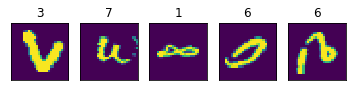

In [0]:
error_mask = y_pred != y_test
plot_example(x_test[error_mask], y_pred[error_mask])

In [0]:
wfc1=rscv.best_estimator_.module_.fc1.weight.data.cpu().numpy()
wfc2=rscv.best_estimator_.module_.fc2.weight.data.cpu().numpy()
wfc3=rscv.best_estimator_.module_.fc3.weight.data.cpu().numpy()


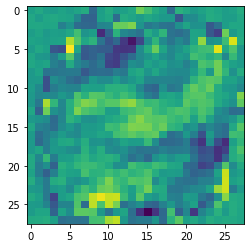

In [0]:
plt.imshow(wfc1[0].reshape(28,28) )


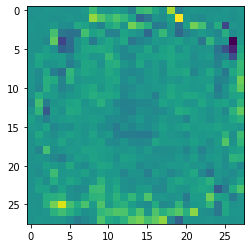

In [0]:
plt.imshow(np.matmul(wfc2[0], wfc1).reshape(28,28))

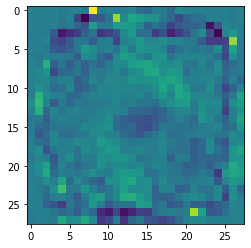

In [0]:
plt.imshow(np.matmul(wfc3[0], np.matmul(wfc2, wfc1)).reshape(28,28))

In [0]:
rscv.best_estimator_.save_params(f_params='pesi.pkl')


In [0]:
new_net = NeuralNetClassifier(
    module=Net,
    module__Ni=784,
    module__Nh1=249,
    module__Nh2=12,
    module__No=10,
    module__dropout=0
)

new_net.initialize() # This is important!
new_net.load_params(f_params='pesi.pkl')

In [0]:
y_pred_new = new_net.predict(x_test)
accuracy_score(y_test, y_pred_new)

0.9687